In [134]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## List of tasts

- Add column calory intake per recipe (crawl yummly api)
- Analyse distribution of lipid/protein/carbs in cuisines
- Show PCA graph of recipes and flavours
- Cluster using K-Means 

We will try to answer the following question in our exploratory analysis:
- What are the most representative ingredients of a cuisine?
- TFIDF + model -> predidct representative recipes

In [20]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import functools


In [21]:
def load_data(data_folder='data/'):
    '''Helper function to load and concat data'''
    df = None
    for file in os.listdir(data_folder):
        if 'DS_' in file:
            continue
        file_path = os.path.join(data_folder, file)
        with open(file_path) as sd:
            data = json.load(sd)['matches']
        cdf = pd.DataFrame(data)
        cdf['cuisine'] = file.split(".")[0].split("_")[-2]
        df = cdf if df is None else pd.concat([df, cdf])
        #print("For {} cuisine we have {} recipes (from {} recipes)".format(file.split(".")[0], len(cdf[cdf['flavors'].apply(lambda x: not x is None)]), len(cdf)))
    df = df[['flavors', 'id', 'ingredients', 'recipeName', 'cuisine']]
    return df

In [36]:
df = load_data()
df = df.drop_duplicates(['id'])
df = df.reset_index(drop=True)



In [37]:
sample = df.sample(n=20)
sample

,flavors,id,ingredients,recipeName,cuisine
1650,None,Cheddar-French-Toast-with-Crab-Hollandaise-162...,"[fat free half and half, large eggs, garlic sa...",Cheddar French Toast with Crab Hollandaise,french
13286,"{'piquant': 0.5, 'meaty': 0.16666666666666666,...",Grilled-Swedish-Meatball-Kebabs-Food_com-124874,"[ground beef, ground pork, fresh breadcrumbs, ...",Grilled Swedish Meatball Kebabs,swedish
6990,None,Hungarian-Rice-With-Meat-_husos-Rizs_-Recipezaar,"[cooked white rice, corn oil, yellow onion, re...",Hungarian Rice With Meat (Husos Rizs),hungarian
5243,"{'piquant': 0.8333333333333334, 'meaty': 0.166...",Navratan-Korma-1768431,"[carrots, capsicum, potatoes, cauliflower flor...",Navratan Korma,indian
16052,None,Thai-Chickpea-Stew-1772276,"[onions, green bell pepper, zucchini, garlic, ...",Thai Chickpea Stew,thai
3346,"{'piquant': 0.6666666666666666, 'meaty': 0.333...",Moroccan-Style-Stew-1309627,"[ground beef, dried oregano, ground nutmeg, be...",Moroccan-Style Stew,moroccan
11930,None,Easy-Orange-Chicken-786297,"[boneless skinless chicken breast halves, oran...",Easy Orange Chicken,chinese
5587,None,Ann-Herrmann_s-Maple-Barbecue-Ribs-1537278,"[maple syrup, spicy brown mustard, apple cider...",Ann Herrmann's Maple Barbecue Ribs,american
8272,None,Vegetable-Teriyaki-Quinoa-Bowl-1803273,"[quinoa, water, vegetable oil, tofu, broccoli,...",Vegetable Teriyaki Quinoa Bowl,japanese
15556,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",Greek-Chicken-with-Rice-AllRecipes,"[olive oil, boneless skinless chicken breasts,...",Greek Chicken with Rice,greek


In [38]:
# Example of one recipe and the attributes that go with it
a = [print(a) for a in df.sample(n=20).values[0]]

{'piquant': 0.16666666666666666, 'meaty': 0.8333333333333334, 'bitter': 0.6666666666666666, 'sweet': 0.16666666666666666, 'sour': 0.16666666666666666, 'salty': 0.8333333333333334}
Chicken-Cordon-Bleu-Panini-995152
['chicken cutlets', 'flour', 'eggs', 'panko breadcrumbs', 'salt', 'pepper', 'olive oil', 'Ciabatta rolls', 'butter', 'dijon mustard', 'swiss cheese', 'deli ham']
Chicken Cordon Bleu Panini
french


In [39]:
# Listing all the possible ingredients
def get_list_ingredients(df):
    possible_ingredients = {}
    for a  in df['ingredients']:
        for ing in a:
            possible_ingredients[ing] = 1 if(not ing in possible_ingredients) else possible_ingredients[ing]+1
    ing_data = np.array([(key,possible_ingredients[key]) for key in possible_ingredients.keys()])
    df_ing = pd.DataFrame(data={'Ingredient': ing_data[:,0], 'Number of apparition':ing_data[:,1].astype(np.int32)})
    return df_ing

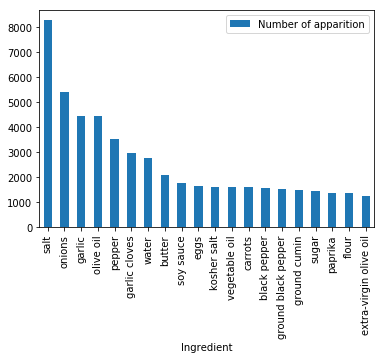

In [40]:
get_list_ingredients(df).sort_values(by='Number of apparition', ascending=False).head(20).plot(x='Ingredient', y='Number of apparition', kind='bar')

We notice that a lot of ingredients are written in different ways (e.g. salt and kosher salt).

In [41]:
list_cuisines = df['cuisine'].unique()
print(list_cuisines)

['spanish' 'french' 'irish' 'moroccan' 'cuban' 'indian' 'american'
 'hungarian' 'hawaiian' 'japanese' 'italian' 'mexican' 'english' 'chinese'
 'swedish' 'german' 'portuguese' 'greek' 'thai']


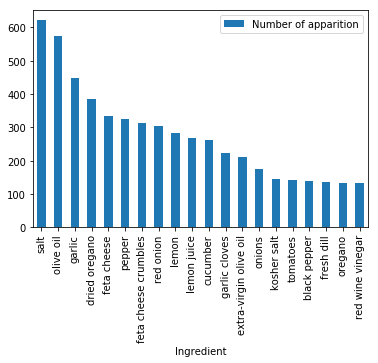

In [42]:
df_ing = get_list_ingredients(df.loc[df.cuisine == list_cuisines[-2]])
df_ing.sort_values(by='Number of apparition', ascending=False).head(20).plot(x='Ingredient', y='Number of apparition', kind='bar')

In [43]:
rank = {0:0,0.16666667 :1,0.33333333:2, 0.5:3,0.66666667:4,0.83333333:5,1:6}
df['flavors'].iloc[0]
df['bitter'] = None
df['salty'] = None
df['piquant']= None
df['sour']= None
df['sweet']= None

def separate_flav_column(x):
    if x.flavors is not None:
        for (k,v)in  x.flavors.items():
            if(v is not None):
                x[k]= rank[round(v,8)]
            else:
                x[k] = v
    return x
df = df.apply(separate_flav_column,axis=1)

In [44]:
sample = (df.sample(10).reset_index(drop=True))

def draw_radar_graph(df, index,
                    title=''):
    labels = np.array(['piquant', 'meaty', 'bitter', 'sweet', 'sour', 'salty'])
    stats = df.loc[index, labels].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
    
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    
    fig= plt.figure()
    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
    ax.set_title(title)
    return ax

,bitter,meaty,piquant,salty,sour,sweet
cuisine,,,,,,
american,2.541478,2.544495,1.835596,2.843137,2.494721,1.345400
chinese,3.396149,2.583219,1.364512,4.001376,2.583219,1.654746
cuban,2.154265,2.473684,1.885662,2.765880,3.455535,1.279492
english,2.239344,2.608197,1.470492,2.644262,2.108197,1.078689
french,2.033094,2.483453,0.732374,2.351079,2.064748,1.060432
german,2.482005,2.438303,0.791774,3.196658,2.370180,1.223650
greek,2.454054,2.218919,0.668919,2.885135,2.979730,1.112162
hawaiian,2.941620,1.967985,1.602637,3.838041,3.913371,2.608286
hungarian,1.714567,1.872047,2.187008,2.169291,2.797244,1.116142


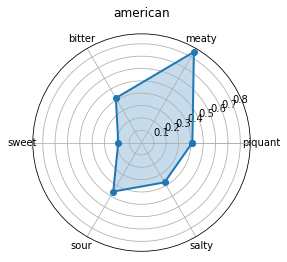

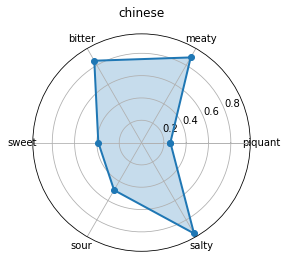

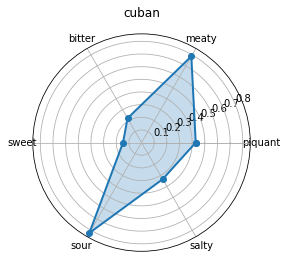

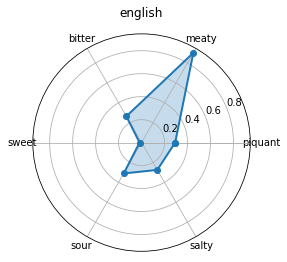

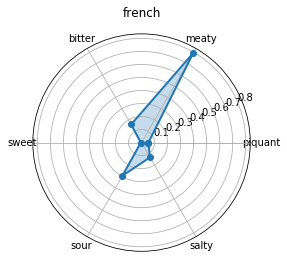

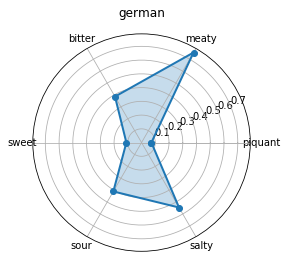

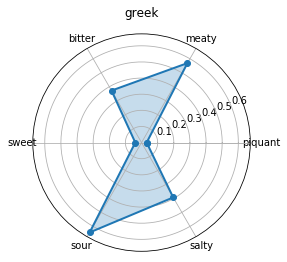

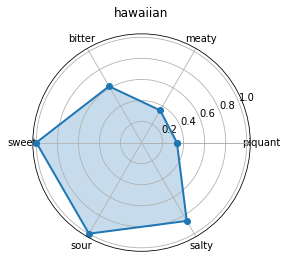

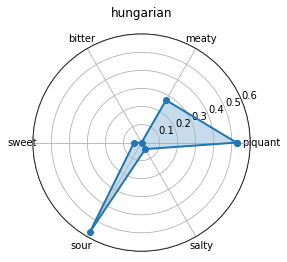

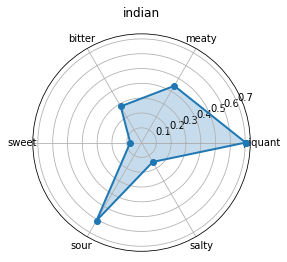

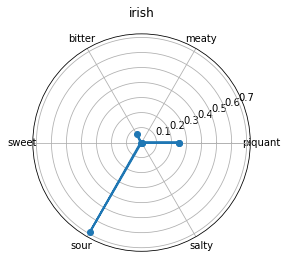

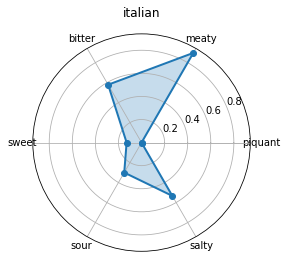

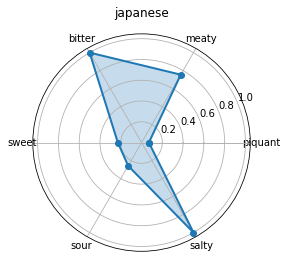

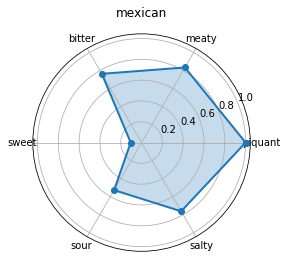

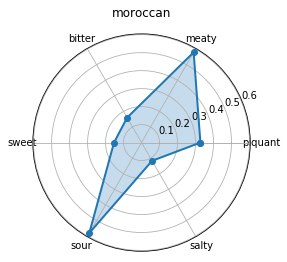

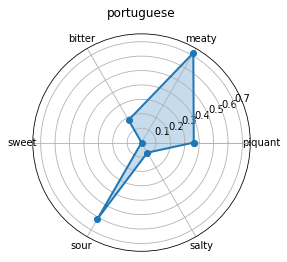

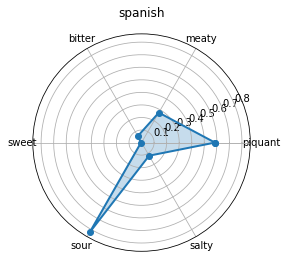

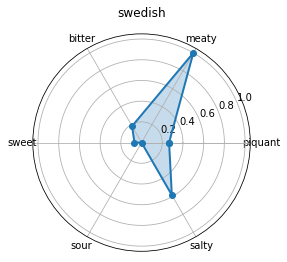

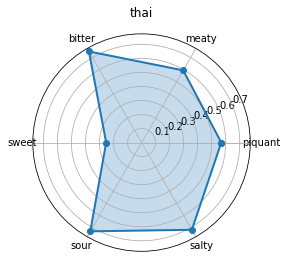

In [45]:
sample = df.reset_index(drop=True)


flavors_cuisines = sample.groupby(by='cuisine').agg('mean')
display(flavors_cuisines)
flavors_cuisines[['piquant', 'meaty', 'bitter', 'sweet', 'sour', 'salty']] = flavors_cuisines[['piquant', 'meaty', 'bitter', 'sweet', 'sour', 'salty']].apply(lambda x: (x-x.min())/(x.max()-x.min()))

for cuisine in flavors_cuisines.index:
    draw_radar_graph(flavors_cuisines, cuisine, title=cuisine)



In [46]:
df[df.recipeName.str.contains('Kung')]
print(len(df[(df.piquant >=4) & (df.cuisine == 'chinese')]),len(df[(df.cuisine == 'chinese')]))


117 989


In [47]:
import string
#Create a set containing all ingredients
ingr = set()
df.ingredients.apply(lambda x: [ingr.add(y) for y in x])
#converting ingredients to text

text_ingredients = df.ingredients.apply(lambda l_ingredients : functools.reduce(lambda acc,x : acc +' ' +x,map(lambda ingred: ingred.translate(str.maketrans('', '', string.whitespace)),l_ingredients)))



In [64]:
# Vectorize recipes
vectorizer = TfidfVectorizer(stop_words=None)
vectors = vectorizer.fit_transform(text_ingredients)



In [65]:
df.set_index
cuisines_label = pd.get_dummies(df.cuisine)
cuisines_classes = cuisines_label.columns.tolist()
df.cuisine = df.cuisine.astype('category')

'''
for cuisine in cuisines_classes:
    logistic = LogisticRegression()
    logistic.fit(vectors,cuisines_label[cuisine])
    print(logistic.predict_proba(vectors))
    recipes_to_cuisine.loc[:,cuisine]= logistic.predict_proba(vectors)
'''
logistic = LogisticRegression(multi_class= 'multinomial',solver='lbfgs')
logistic.fit(vectors,df.cuisine.astype('category').cat.codes)
predicted_probas = logistic.predict_proba(vectors)


In [66]:
recipes_to_cuisine_1 = pd.DataFrame(predicted_probas,columns =  df.cuisine.cat.categories)
recipes_to_cuisine_1 = pd.concat([df.id,recipes_to_cuisine_1],axis = 1)
recipes_to_cuisine_1 = recipes_to_cuisine_1.set_index('id',drop = True)
recipes_to_cuisine_1['classes'] = logistic.predict(vectors)




In [67]:
def apply_func(x):
    temp =recipes_to_cuisine_1.loc[x.id,'classes'].astype(int)
    return (recipes_to_cuisine_1.loc[x.id,x.cuisine] >= 0.6) and (df.cuisine.cat.categories.tolist()[temp] == x.cuisine)
df['keep'] = df.apply(apply_func  ,axis = 1)

In [68]:
df[df['keep']]

,bitter,cuisine,flavors,id,ingredients,meaty,piquant,recipeName,salty,sour,sweet,keep
0,2.0,spanish,"{'piquant': 0.6666666666666666, 'meaty': 0.166...",Easy-Seafood-Paella-2077829,"[lobster tails, water, olive oil, yellow onion...",1.0,4.0,Easy Seafood Paella,1.0,1.0,1.0,True
1,NaN,spanish,None,Skillet-Grilled-Seafood-and-Chorizo-Paella_-21...,"[olive oil, sweet onion, garlic, spanish chori...",NaN,NaN,Skillet Grilled Seafood and Chorizo Paella.,NaN,NaN,NaN,True
3,2.0,spanish,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",Classic-Paella-898818,"[extra-virgin olive oil, skinless chicken brea...",1.0,1.0,Classic Paella,1.0,4.0,1.0,True
4,1.0,spanish,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",One-Pot-Spanish-Chicken-and-Rice-2237989,"[olive oil, chicken thighs, salt, pepper, onio...",1.0,1.0,One Pot Spanish Chicken and Rice,1.0,5.0,1.0,True
5,1.0,spanish,"{'piquant': 0.5, 'meaty': 0.16666666666666666,...",Portuguese-fish-stew-306395,"[plum tomatoes, savoy cabbage, extra-virgin ol...",1.0,3.0,Portuguese Fish Stew,2.0,3.0,1.0,True
6,4.0,spanish,"{'piquant': 0.3333333333333333, 'meaty': 0.166...",Portuguese-Seafood-Stew-2139944,"[littleneck clams, large shrimp, scallops, ext...",1.0,2.0,Portuguese Seafood Stew,1.0,4.0,1.0,True
7,NaN,spanish,None,Paella-578302,"[saffron, chicken thighs, large shrimp, ground...",NaN,NaN,Paella,NaN,NaN,NaN,True
9,3.0,spanish,"{'piquant': 0.8333333333333334, 'meaty': 0.833...",Spanish-Chicken-with-Chorizo-and-Potatoes-679012,"[olive oil, chicken thighs, chorizo sausage, b...",5.0,5.0,Spanish Chicken with Chorizo and Potatoes,3.0,3.0,1.0,True
10,1.0,spanish,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",Mushroom-Paella-2040267,"[cremini, dried porcini mushrooms, olive oil, ...",1.0,1.0,Mushroom Paella,1.0,4.0,1.0,True
11,2.0,spanish,"{'piquant': 0.8333333333333334, 'meaty': 0.833...",Spanish-Chicken-with-Chorizo-and-Potatoes-2074171,"[olive oil, chicken thighs, chorizo, potatoes,...",5.0,5.0,Spanish Chicken with Chorizo and Potatoes,3.0,4.0,1.0,True


10772


,bitter,meaty,piquant,salty,sour,sweet,keep
cuisine,,,,,,,
american,2.446886,2.582418,2.021978,2.750916,2.505495,1.439560,True
chinese,3.451839,2.639229,1.437828,4.084063,2.513135,1.623468,True
cuban,2.138889,2.540123,1.660494,2.731481,3.537037,1.246914,True
english,2.240000,3.005714,1.600000,2.777143,1.880000,1.074286,True
french,1.932249,2.460705,0.653117,2.097561,2.037940,1.035230,True
german,2.622680,2.367010,0.690722,3.334021,2.461856,1.263918,True
greek,2.457377,2.168852,0.657377,2.936066,2.963934,1.093443,True
hawaiian,2.979167,1.945312,1.658854,3.950521,4.239583,2.791667,True
hungarian,1.649701,1.895210,2.338323,2.125749,2.634731,1.137725,True


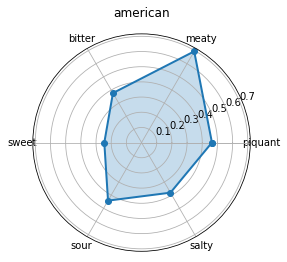

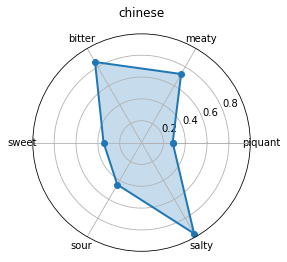

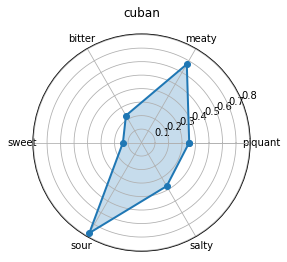

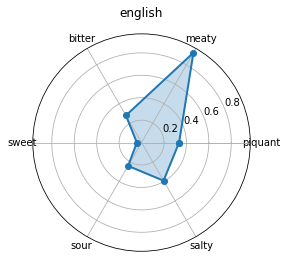

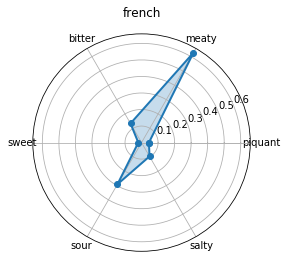

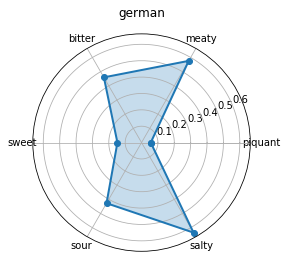

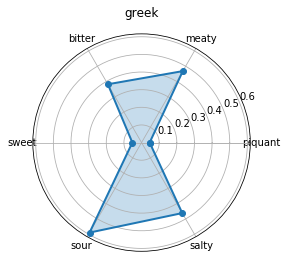

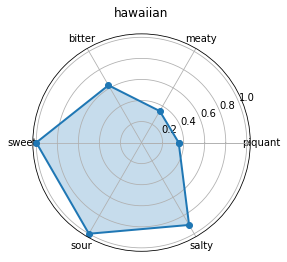

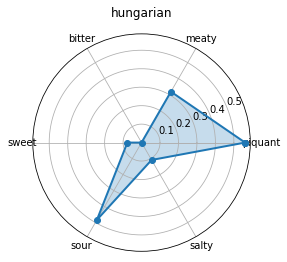

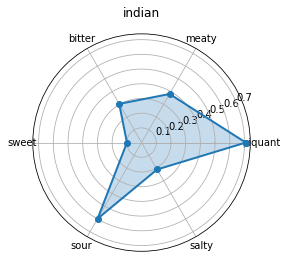

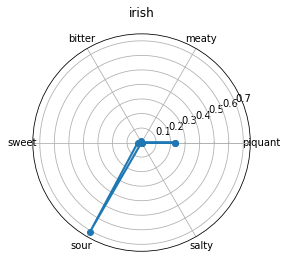

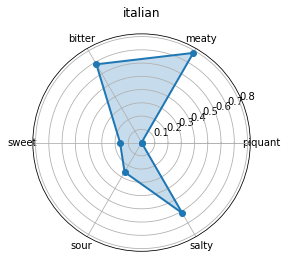

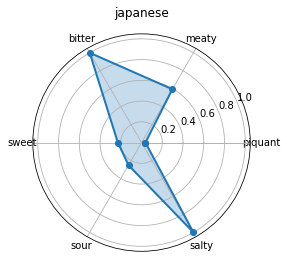

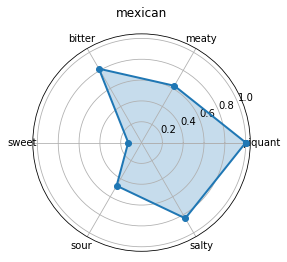

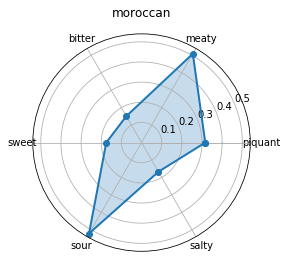

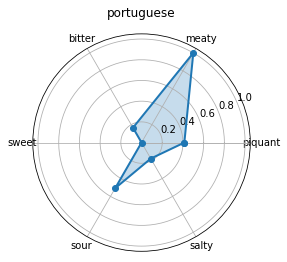

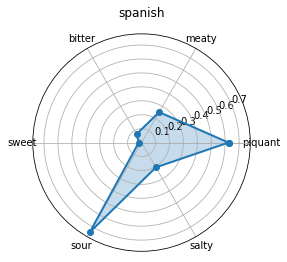

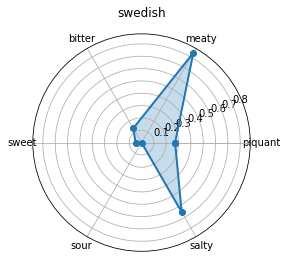

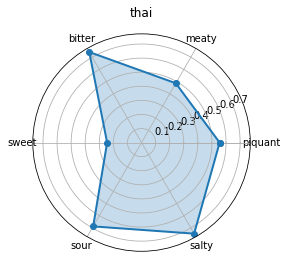

In [69]:
print(len(df[df['keep']]))
flavors_cuisines = df[df['keep']].groupby(by='cuisine').agg('mean')
display(flavors_cuisines)
flavors_cuisines[['piquant', 'meaty', 'bitter', 'sweet', 'sour', 'salty']] = flavors_cuisines[['piquant', 'meaty', 'bitter', 'sweet', 'sour', 'salty']].apply(lambda x: (x-x.min())/(x.max()-x.min()))

for cuisine in flavors_cuisines.index:
    draw_radar_graph(flavors_cuisines, cuisine, title=cuisine)



In [100]:

logistic.coef_[0,np.argsort(-logistic.coef_[0])][:20]

array([ 4.67045375,  3.41890914,  3.26877088,  3.11574884,  2.9441137 ,
        2.85975481,  2.85649113,  2.84784472,  2.8319112 ,  2.68944947,
        2.59585752,  2.51226948,  2.47072706,  2.4682582 ,  2.45764198,
        2.36211784,  2.35944476,  2.33493933,  2.33309603,  2.32113863])

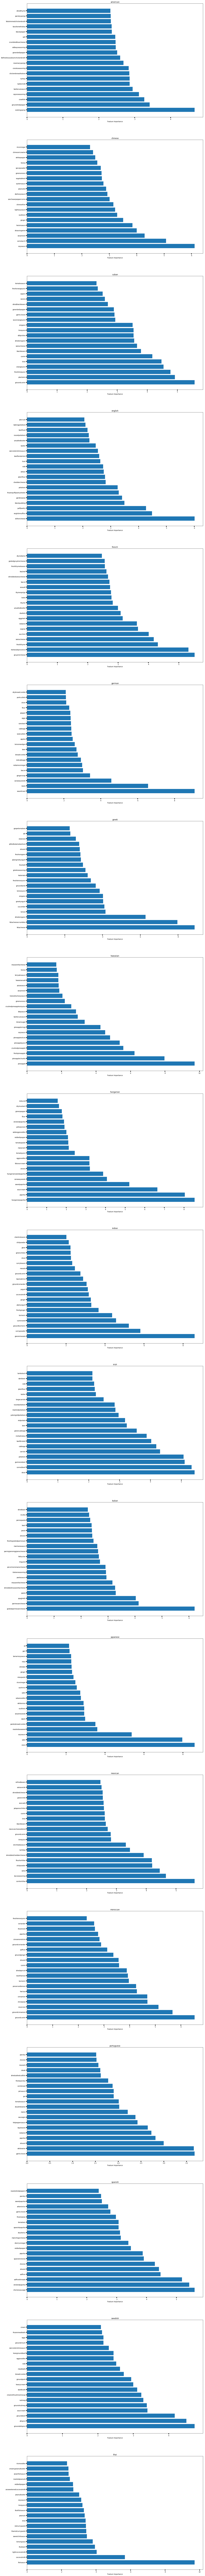

In [135]:
import matplotlib.ticker as ticker

top_20 = list()
#Top ingredients in every cuisine
f,ax = plt.subplots(19,1)
f.set_size_inches(20,300)
for i in range(19):
    top_features = np.argsort(-logistic.coef_[i])[:20]
    top_20.append(top_features)
    features_names = vectorizer.get_feature_names()


    ax[i].barh(range(20), logistic.coef_[i,top_features], align='center')
    ax[i].set_yticks(np.arange(20))
    ax[i].set_yticklabels([features_names[i] for i in top_features])
    ax[i].set_xlabel('Feature Importance')
    ax[i].set_title(df.cuisine.cat.categories[i])
    ax[i].tick_params(direction='out', length=6, width=4)


In [101]:
vectorizer.get_feature_names()

['10oz',
 '14',
 '15groundturkey',
 '1inchthick',
 '21',
 '2to3lb',
 '33',
 '40',
 '50',
 '5oz',
 '85',
 '95',
 '98',
 '99',
 'a1steaksauce',
 'abckecapmanis',
 'aburaage',
 'accentseasoning',
 'achiote',
 'achiotepaste',
 'achiotepowder',
 'acorn',
 'acornsquash',
 'actingbakingpowder',
 'activedryyeast',
 'addedblackbeans',
 'addeddicedtomatoes',
 'adobo',
 'adoboall',
 'adobosauce',
 'adoboseasoning',
 'agar',
 'agavenectar',
 'agedbalsamicvinegar',
 'agedmanchegocheese',
 'agedsherryvinegar',
 'ahi',
 'ahitunasteaks',
 'aioli',
 'ajimirin',
 'ajinomoto',
 'ajvar',
 'ajwain',
 'akamiso',
 'alaskahalibutfillets',
 'albacore',
 'alcohol',
 'ale',
 'aleppo',
 'aleppopepper',
 'alfalfasprouts',
 'alfredo',
 'alfredosauce',
 'alfredosaucemix',
 'all',
 'allbeefhotdogs',
 'allnatural',
 'allnaturalreducedsodiumchickenbroth',
 'allpurposeseasoning',
 'allspice',
 'allspiceberries',
 'almondbutter',
 'almondflour',
 'almondmeal',
 'almondmilk',
 'almonds',
 'amba',
 'amberale',
 'amchur',
 